# GPT Sequence Finder: Genomic Detection via Fine-Tuning and Attention Analysis

This notebook implements:
1. **Multi-type data loading**: Load genomic sequences with various masking types
2. **Difficulty analysis**: Empirically measure difficulty of each masking type
3. **Curriculum learning**: Train progressively from easy → hard
4. **Token classification**: Fine-tune GPT-2 with LoRA
5. **Attention analysis**: Extract and visualize attention patterns
6. **Per-type evaluation**: Compare performance across masking types

## 1. Setup and Imports

In [1]:
# Install dependencies (uncomment if needed)
# %pip install transformers datasets peft accelerate torch matplotlib seaborn pandas numpy scikit-learn tqdm
# conda env create -f environment.yml

In [2]:
import os
import re
import random
import warnings
from pathlib import Path
from typing import List, Dict, Tuple
from dataclasses import dataclass, field

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from transformers import (
    GPT2Tokenizer, GPT2Model, GPT2PreTrainedModel, GPT2Config,
    TrainingArguments, Trainer
)
from transformers.modeling_outputs import TokenClassifierOutput
from transformers import EarlyStoppingCallback
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import precision_recall_fscore_support, classification_report

warnings.filterwarnings('ignore')

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [3]:
if torch.backends.mps.is_available():
    torch.mps.empty_cache()

## 2. Configuration

In [4]:
@dataclass
class Config:
    # Data paths
    data_root: str = './dataset_dna'
    masking_types: List[str] = field(default_factory=lambda: [
        'text_and_seq',
        'text_and_seq_alternate_random_characters',
        'text_and_seq_compressed',
        'text_and_seq_compressed_and_replaced',
        'text_and_seq_fuzzed_ambiguity_codes',
        'text_and_seq_fuzzed_case_and_whitespace',
        'text_and_seq_fuzzed_character_substitution',
        'text_and_seq_fuzzed_numerical_interleaving',
        'text_and_seq_fuzzed_random_character_insertion',
    ])
    difficulty_tiers: Dict[str, List[str]] = field(default_factory=dict)
    
    # Model
    model_name: str = 'gpt2' #'distilgpt2'  # Keeping GPT-2
    num_labels: int = 2
    
    # LoRA - Increased capacity for better learning
    lora_r: int = 8        # Changed back: 16→8 (less capacity)
    lora_alpha: int = 16   # Changed back: 32→16          # Changed: 16→32 (scales with r)
    # LoRA config
    lora_dropout: float = 0.2      # Changed: 0.1→0.2 (more aggressive)
    lora_target_modules: List[str] = field(default_factory=lambda: ['c_attn', 'c_proj'])
    
    # Training
    max_length: int = 512
    batch_size: int = 4           # Changed: 8→4 (better for small dataset)
    learning_rate: float = 2e-5    # Changed: 5e-5→2e-5 (slower, more careful)  # Changed: 2e-4→5e-5 (more stable)
    weight_decay: float = 0.05
    warmup_ratio: float = 0.1
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    # Curriculum - More time on harder tiers
    curriculum_epochs: Dict[str, int] = field(default_factory=lambda: {
    'easy': 1,      # Changed: 2→1 (already at 99.5% F1)
    'medium': 3,    # Keep
    'hard': 5,      # Keep
    })
    
    # Data splits
    train_split: float = 0.85     # Changed: 0.8→0.85 (maximize training data)
    
    # Output
    output_dir: str = './outputs'
    
    def __post_init__(self):
        for d in [self.output_dir, f'{self.output_dir}/checkpoints', 
                  f'{self.output_dir}/figures', f'{self.output_dir}/attention']:
            os.makedirs(d, exist_ok=True)

config = Config()
print(f'Data root: {config.data_root}')
print(f'Masking types: {len(config.masking_types)}')

Data root: ./dataset_dna
Masking types: 9


## 3. Data Loading

In [5]:
class MultiTypeDataLoader:
    """Load genomic data from multiple masking type folders."""
    
    # Define column mappings per folder type
    COLUMN_MAPPINGS = {
        'text_and_seq': {
            'sequence_col': 'sequence',
            'masked_col': 'generated',  # Different column name!
            'negative_col': None,
        },
        'english_and_seq': {
            'sequence_col': 'sequence',
            'masked_col': 'text_with_dna',
            'negative_col': 'text_without_dna',
        },
        'text_and_seq_alternate_random_characters': {
            'sequence_col': 'sequence',
            'masked_col': 'text_with_dna',
            'negative_col': 'text_without_dna',
        },
        'text_and_seq_compressed': {
            'sequence_col': 'sequence',
            'masked_col': 'text_with_dna',
            'compressed_col': 'compressed',
            'negative_col': 'text_without_dna',
        },
        'text_and_seq_compressed_and_replaced': {
            'sequence_col': 'sequence',
            'masked_col': 'text_with_dna',
            'compressed_col': 'compressed',
            'negative_col': 'text_without_dna',
        },
        'text_and_seq_fuzzed_ambiguity_codes': {
            'sequence_col': 'sequence',
            'masked_col': 'text_with_dna',
            'negative_col': 'text_without_dna',
        },
        'text_and_seq_fuzzed_case_and_whitespace': {
            'sequence_col': 'sequence',
            'masked_col': 'text_with_dna',
            'negative_col': 'text_without_dna',
        },
        'text_and_seq_fuzzed_character_substitution': {
            'sequence_col': 'sequence',
            'masked_col': 'text_with_dna',
            'negative_col': 'text_without_dna',
        },
        'text_and_seq_fuzzed_numerical_interleaving': {
            'sequence_col': 'sequence',
            'masked_col': 'text_with_dna',
            'negative_col': 'text_without_dna',
        },
        'text_and_seq_fuzzed_random_character_insertion': {
            'sequence_col': 'sequence',
            'masked_col': 'text_with_dna',
            'negative_col': 'text_without_dna',
        },
    }
    
    def __init__(self, data_root: str, masking_types: List[str]):
        self.data_root = Path(data_root)
        self.masking_types = masking_types
    
    def _find_inserted_region(self, text_with_dna: str, text_without_dna: str) -> Tuple[int, int, str]:
        """
        Find the genomic region by comparing text_with_dna and text_without_dna.
        The inserted region is what's different between them.
        """
        # Find common prefix
        prefix_len = 0
        min_len = min(len(text_with_dna), len(text_without_dna))
        while prefix_len < min_len and text_with_dna[prefix_len] == text_without_dna[prefix_len]:
            prefix_len += 1
        
        # Find common suffix
        suffix_len = 0
        while (suffix_len < min_len - prefix_len and 
               text_with_dna[-(suffix_len + 1)] == text_without_dna[-(suffix_len + 1)]):
            suffix_len += 1
        
        # The genomic region is between prefix and suffix in text_with_dna
        if suffix_len > 0:
            g_start = prefix_len
            g_end = len(text_with_dna) - suffix_len
        else:
            g_start = prefix_len
            g_end = len(text_with_dna)
        
        genomic_seq = text_with_dna[g_start:g_end]
        
        return g_start, g_end, genomic_seq
    
    def parse_csv(self, filepath: Path, masking_type: str) -> List[Dict]:
        """Parse single CSV file based on masking type."""
        samples = []
        
        try:
            df = pd.read_csv(filepath)
        except Exception as e:
            print(f'Error reading {filepath}: {e}')
            return []
        
        if len(df) == 0:
            return []
        
        row = df.iloc[0]
        
        # Base case: text_and_seq uses 'sequence' and 'generated' columns
        if masking_type == 'text_and_seq':
            if 'sequence' in df.columns and 'generated' in df.columns:
                genomic_seq = str(row['sequence']).upper()
                masked_seq = str(row['generated'])
                
                # Find genomic position in masked sequence
                g_start = masked_seq.upper().find(genomic_seq)
                if g_start == -1:
                    # Try partial match
                    for length in range(len(genomic_seq), 20, -1):
                        g_start = masked_seq.upper().find(genomic_seq[:length])
                        if g_start != -1:
                            break
                
                if g_start != -1:
                    samples.append({
                        'genomic_sequence': genomic_seq,
                        'masked_sequence': masked_seq,
                        'genomic_start': g_start,
                        'genomic_end': g_start + len(genomic_seq),
                        'filepath': str(filepath),
                        'masking_type': masking_type,
                    })
            return samples
        
        # All other folders: use text_with_dna and text_without_dna comparison
        if 'text_with_dna' in df.columns and 'text_without_dna' in df.columns:
            text_with = str(row['text_with_dna'])
            text_without = str(row['text_without_dna'])
            
            # Find the inserted genomic region by comparing the two texts
            g_start, g_end, genomic_seq = self._find_inserted_region(text_with, text_without)
            
            if g_end > g_start and len(genomic_seq) > 10:  # Sanity check
                samples.append({
                    'genomic_sequence': genomic_seq,
                    'masked_sequence': text_with,
                    'genomic_start': g_start,
                    'genomic_end': g_end,
                    'filepath': str(filepath),
                    'masking_type': masking_type,
                })
        
        return samples
    
    def load_type(self, masking_type: str) -> List[Dict]:
        """Load all entries for a masking type."""
        folder = self.data_root / masking_type
        if not folder.exists():
            print(f'Warning: {folder} not found')
            return []
        
        data = []
        files = sorted(folder.glob('entry_*.csv'), 
                      key=lambda x: int(re.search(r'entry_(\d+)', x.stem).group(1)))
        
        for fp in files:
            samples = self.parse_csv(fp, masking_type)
            for s in samples:
                s['entry_id'] = int(re.search(r'entry_(\d+)', fp.stem).group(1))
            data.extend(samples)
        
        return data
    
    def load_all(self) -> Dict[str, List[Dict]]:
        """Load all masking types."""
        all_data = {}
        for mt in tqdm(self.masking_types, desc='Loading data'):
            data = self.load_type(mt)
            all_data[mt] = data
            print(f'  {mt}: {len(data)} samples')
        print(f'Total: {sum(len(v) for v in all_data.values())} samples')
        return all_data

In [6]:
# Load data
loader = MultiTypeDataLoader(config.data_root, config.masking_types)
all_data = loader.load_all()

Loading data:   0%|          | 0/9 [00:00<?, ?it/s]

  text_and_seq: 1000 samples
  text_and_seq_alternate_random_characters: 200 samples
  text_and_seq_compressed: 200 samples
  text_and_seq_compressed_and_replaced: 200 samples
  text_and_seq_fuzzed_ambiguity_codes: 200 samples
  text_and_seq_fuzzed_case_and_whitespace: 200 samples
  text_and_seq_fuzzed_character_substitution: 200 samples
  text_and_seq_fuzzed_numerical_interleaving: 200 samples
  text_and_seq_fuzzed_random_character_insertion: 200 samples
Total: 2600 samples


In [7]:
len(all_data)

9

In [8]:
# Preview samples
for mt, samples in all_data.items():
    if samples:
        s = samples[0]
        print(f'\n--- {mt} ---')
        print(f'Genomic (50 chars): {s["genomic_sequence"][:50]}...')
        print(f'Masked (80 chars): {s["masked_sequence"][:80]}...')


--- text_and_seq ---
Genomic (50 chars): GTGCTGGCGTTTGTACTCATGCAGACGTTTGATCTGAATATCGAAAATCG...
Masked (80 chars): MZ%/$lPnH7b.2%16kdiUVeTopjmt#HIJnOtiRHnZ&hnv9QXo?eCb@*dnAyX0dBrAvG06MSMq9S0LjbI3...

--- text_and_seq_alternate_random_characters ---
Genomic (50 chars): g8t$t6c0Abt	tzgrAQAQcscVgDt	A7tytXt6Adcng5A
t1cfAY...
Masked (80 chars): The cat sat on the mat. "Here is a very interesting piece of data," she purred, ...

--- text_and_seq_compressed ---
Genomic (50 chars): TGCAT5ACGC2ATC2GCGC2AG2CGCGATCAGACGAGCT2CT2CA2TCA2...
Masked (80 chars): Scanning completed. The bio-signature data stream, raw and untranslated, present...

--- text_and_seq_compressed_and_replaced ---
Genomic (50 chars): HwH^wDwHwDHwDHDHD^DH^Dw^D^wDH^Dw^DwD^HD^wDwD^DH^H^...
Masked (80 chars): A faint murmur of data, perhaps a forgotten log entry from an old server. The by...

--- text_and_seq_fuzzed_ambiguity_codes ---
Genomic (50 chars): TRCAT5ACGB2ATR2GCGC2AGWCGWVATCAGACGAGRTNCT2CA2TCHB...
Masked (80 chars): Sca

## 4. Difficulty Analysis

In [9]:
def sample_from_each_type(all_data, n_samples=3):
    """Extract sample data from each masking type."""
    
    samples = {}
    
    for masking_type, data in all_data.items():
        if not data:
            continue
        
        samples[masking_type] = []
        
        for i in range(min(n_samples, len(data))):
            sample = data[i]
            samples[masking_type].append({
                'entry_id': sample.get('entry_id', i),
                'genomic_sequence': sample['genomic_sequence'][:100] + '...' if len(sample['genomic_sequence']) > 100 else sample['genomic_sequence'],
                'masked_sequence': sample['masked_sequence'][:200] + '...' if len(sample['masked_sequence']) > 200 else sample['masked_sequence'],
                'genomic_start': sample['genomic_start'],
                'genomic_end': sample['genomic_end'],
                'genomic_length': len(sample['genomic_sequence']),
                'masked_length': len(sample['masked_sequence']),
            })
    
    return samples

# Generate samples
samples = sample_from_each_type(all_data, n_samples=3)

# Print in readable format
for masking_type, entries in samples.items():
    print(f"\n{'='*80}")
    print(f"MASKING TYPE: {masking_type}")
    print(f"{'='*80}")
    
    for i, entry in enumerate(entries, 1):
        print(f"\n--- Sample {i} (Entry {entry['entry_id']}) ---")
        print(f"Genomic length: {entry['genomic_length']}")
        print(f"Masked length: {entry['masked_length']}")
        print(f"Position: {entry['genomic_start']} - {entry['genomic_end']}")
        print(f"\nGenomic (first 100 chars):\n{entry['genomic_sequence']}")
        print(f"\nMasked (first 200 chars):\n{entry['masked_sequence']}")


MASKING TYPE: text_and_seq

--- Sample 1 (Entry 0) ---
Genomic length: 875
Masked length: 8225
Position: 201 - 1076

Genomic (first 100 chars):
GTGCTGGCGTTTGTACTCATGCAGACGTTTGATCTGAATATCGAAAATCGCCTGTGGATTGATCTCAATACCGGTACGAACTTTCACAAACTCCGCCAGA...

Masked (first 200 chars):
MZ%/$lPnH7b.2%16kdiUVeTopjmt#HIJnOtiRHnZ&hnv9QXo?eCb@*dnAyX0dBrAvG06MSMq9S0LjbI3P.xD5owDsDiajC46t3g8/8$8iEUcDD.DVgRm0jKMUQWlZHYUiQ*sSsW7?6lgcsUZGzlmAs7q,K$IXCBi#vE7O&$bfct$C,!&2k?gJ,A8NxftCS3V&I6 E3YP...

--- Sample 2 (Entry 1) ---
Genomic length: 6889
Masked length: 16414
Position: 954 - 7843

Genomic (first 100 chars):
GTTTGATTAAATTTGTCCGCAACCGGACGATTCGCTTTCGGCGTAGCATACCAATAACCCAATCCCATGAATACGGCACCTGATAAAGTATTACCCAGCG...

Masked (first 200 chars):
$gU5C&L#vDydDIhY@ihLe?*sol LFW?9UpA&.2HJPIz%SRpLe?f!k@lv,tgQk$#@Y*%SQ0s*Sbj6!Ot6o08!!kKaCVKA
Emky4zZ27CJB.BPT l5nt7$8$zLmaaqWMD#ps.?BP1sV%L9NXD
*k@$xnk1Uk9OrOqQc57#3rVi9@b4PODJ83MDwJXF@S@qu,Sk%Sz@VT4#...

--- Sample 3 (Entry 2) ---
Genomic length: 9960
Masked length: 19

In [10]:
class DifficultyAnalyzer:
    """Analyze and rank difficulty of masking types."""
    
    GENOMIC_CHARS = set('ATGC')
    IUPAC_AMBIGUITY = set('RYSWKMBDHVN')
    
    def __init__(self, all_data):
        self.all_data = all_data
    
    def compute_metrics(self, sample: Dict) -> Dict:
        """Compute difficulty metrics for a single sample."""
        genomic = sample['genomic_sequence']
        masked = sample['masked_sequence']
        
        if len(genomic) == 0:
            return None
        
        # Metric 1: ATGC preservation in genomic sequence
        atgc_count = sum(1 for c in genomic.upper() if c in self.GENOMIC_CHARS)
        atgc_preservation = atgc_count / len(genomic)
        
        # Metric 2: Character diversity in genomic (more diverse = harder)
        unique_chars_genomic = len(set(genomic))
        
        # Metric 3: Presence of numbers in genomic
        has_numbers = any(c.isdigit() for c in genomic)
        number_density = sum(1 for c in genomic if c.isdigit()) / len(genomic)
        
        # Metric 4: Presence of special characters in genomic
        special_chars = set('!@#$%^&*()_+-=[]{}|;:,.<>?/\\~`\'\"')
        special_density = sum(1 for c in genomic if c in special_chars) / len(genomic)
        
        # Metric 5: Presence of IUPAC codes (ambiguity)
        iupac_density = sum(1 for c in genomic.upper() if c in self.IUPAC_AMBIGUITY) / len(genomic)
        
        # Metric 6: Whitespace/newline presence (case/whitespace fuzzing)
        whitespace_density = sum(1 for c in genomic if c.isspace()) / len(genomic)
        
        # Metric 7: Case variation (mixed case = harder)
        if genomic.upper() != genomic and genomic.lower() != genomic:
            has_case_variation = 1.0
        else:
            has_case_variation = 0.0
        
        # Metric 8: Compression indicators (numbers followed by letters)
        compression_pattern = len(re.findall(r'\d+[A-Za-z]', genomic)) / max(1, len(genomic) / 10)
        
        return {
            'atgc_preservation': atgc_preservation,
            'unique_chars': unique_chars_genomic,
            'number_density': number_density,
            'special_density': special_density,
            'iupac_density': iupac_density,
            'whitespace_density': whitespace_density,
            'case_variation': has_case_variation,
            'compression_pattern': compression_pattern,
        }
    
    def analyze_all(self) -> pd.DataFrame:
        """Analyze all masking types and return summary DataFrame."""
        results = []
        
        for masking_type, samples in self.all_data.items():
            if not samples:
                continue
            
            type_metrics = []
            for sample in samples[:50]:  # Sample first 50
                metrics = self.compute_metrics(sample)
                if metrics:
                    type_metrics.append(metrics)
            
            if type_metrics:
                # Average metrics
                avg_metrics = {
                    'masking_type': masking_type,
                    'n_samples': len(samples),
                    'atgc_preservation': np.mean([m['atgc_preservation'] for m in type_metrics]),
                    'unique_chars': np.mean([m['unique_chars'] for m in type_metrics]),
                    'number_density': np.mean([m['number_density'] for m in type_metrics]),
                    'special_density': np.mean([m['special_density'] for m in type_metrics]),
                    'iupac_density': np.mean([m['iupac_density'] for m in type_metrics]),
                    'whitespace_density': np.mean([m['whitespace_density'] for m in type_metrics]),
                    'case_variation': np.mean([m['case_variation'] for m in type_metrics]),
                    'compression_pattern': np.mean([m['compression_pattern'] for m in type_metrics]),
                }
                results.append(avg_metrics)
        
        df = pd.DataFrame(results)
        
        # Compute difficulty score (weighted combination)
        # Higher score = harder to detect
        df['difficulty_score'] = (
            (1 - df['atgc_preservation']) * 10.0 +     # No ATGC = very hard
            (df['unique_chars'] / 50) * 2.0 +          # More char diversity = harder
            df['number_density'] * 5.0 +               # Numbers mixed in = harder
            df['special_density'] * 5.0 +              # Special chars = harder
            df['iupac_density'] * 3.0 +                # IUPAC ambiguity = harder
            df['whitespace_density'] * 2.0 +           # Whitespace = harder
            df['case_variation'] * 1.5 +               # Case mixing = harder
            df['compression_pattern'] * 2.0            # Compression = harder
        )
        
        df = df.sort_values('difficulty_score')
        df['difficulty_rank'] = range(1, len(df) + 1)
        
        return df
    
    def plot_difficulty(self, df: pd.DataFrame, save_path: str = None):
        """Visualize difficulty metrics."""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        df = df.copy()
        df['short_name'] = df['masking_type'].str.replace('text_and_seq_', '').str.replace('text_and_seq', 'base')
        df = df.sort_values('difficulty_score')
        
        # Plot 1: ATGC preservation (lower = harder)
        axes[0, 0].barh(df['short_name'], df['atgc_preservation'], color='steelblue')
        axes[0, 0].set_xlabel('ATGC Preservation (higher = easier)')
        axes[0, 0].set_title('ATGC Character Preservation')
        axes[0, 0].set_xlim(0, 1)
        
        # Plot 2: Number + Special character density
        x = np.arange(len(df))
        w = 0.35
        axes[0, 1].barh(x - w/2, df['number_density'], w, label='Numbers', color='coral')
        axes[0, 1].barh(x + w/2, df['special_density'], w, label='Special Chars', color='salmon')
        axes[0, 1].set_yticks(x)
        axes[0, 1].set_yticklabels(df['short_name'])
        axes[0, 1].set_xlabel('Density')
        axes[0, 1].set_title('Number & Special Character Density')
        axes[0, 1].legend()
        
        # Plot 3: Multiple features
        axes[1, 0].barh(df['short_name'], df['iupac_density'], label='IUPAC', alpha=0.7)
        axes[1, 0].set_xlabel('Density')
        axes[1, 0].set_title('IUPAC Ambiguity Codes')
        
        # Plot 4: Overall difficulty
        colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(df)))
        axes[1, 1].barh(df['short_name'], df['difficulty_score'], color=colors)
        axes[1, 1].set_xlabel('Difficulty Score')
        axes[1, 1].set_title('Overall Difficulty (Higher = Harder)')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        
        plt.show()
        
        return df


Updated Difficulty Analysis:
                                  masking_type  n_samples  atgc_preservation  number_density  special_density  difficulty_score  difficulty_rank
                                  text_and_seq       1000           1.000000        0.000000         0.000000          0.160000                1
                       text_and_seq_compressed        200           0.789726        0.210274         0.000000          7.649631                2
    text_and_seq_fuzzed_numerical_interleaving        200           0.733471        0.235715         0.000000          8.245220                3
           text_and_seq_fuzzed_ambiguity_codes        200           0.673101        0.178675         0.000000          8.883489                4
text_and_seq_fuzzed_random_character_insertion        200           0.719166        0.207742         0.049097          9.029289                5
       text_and_seq_fuzzed_case_and_whitespace        200           0.754006        0.200686        

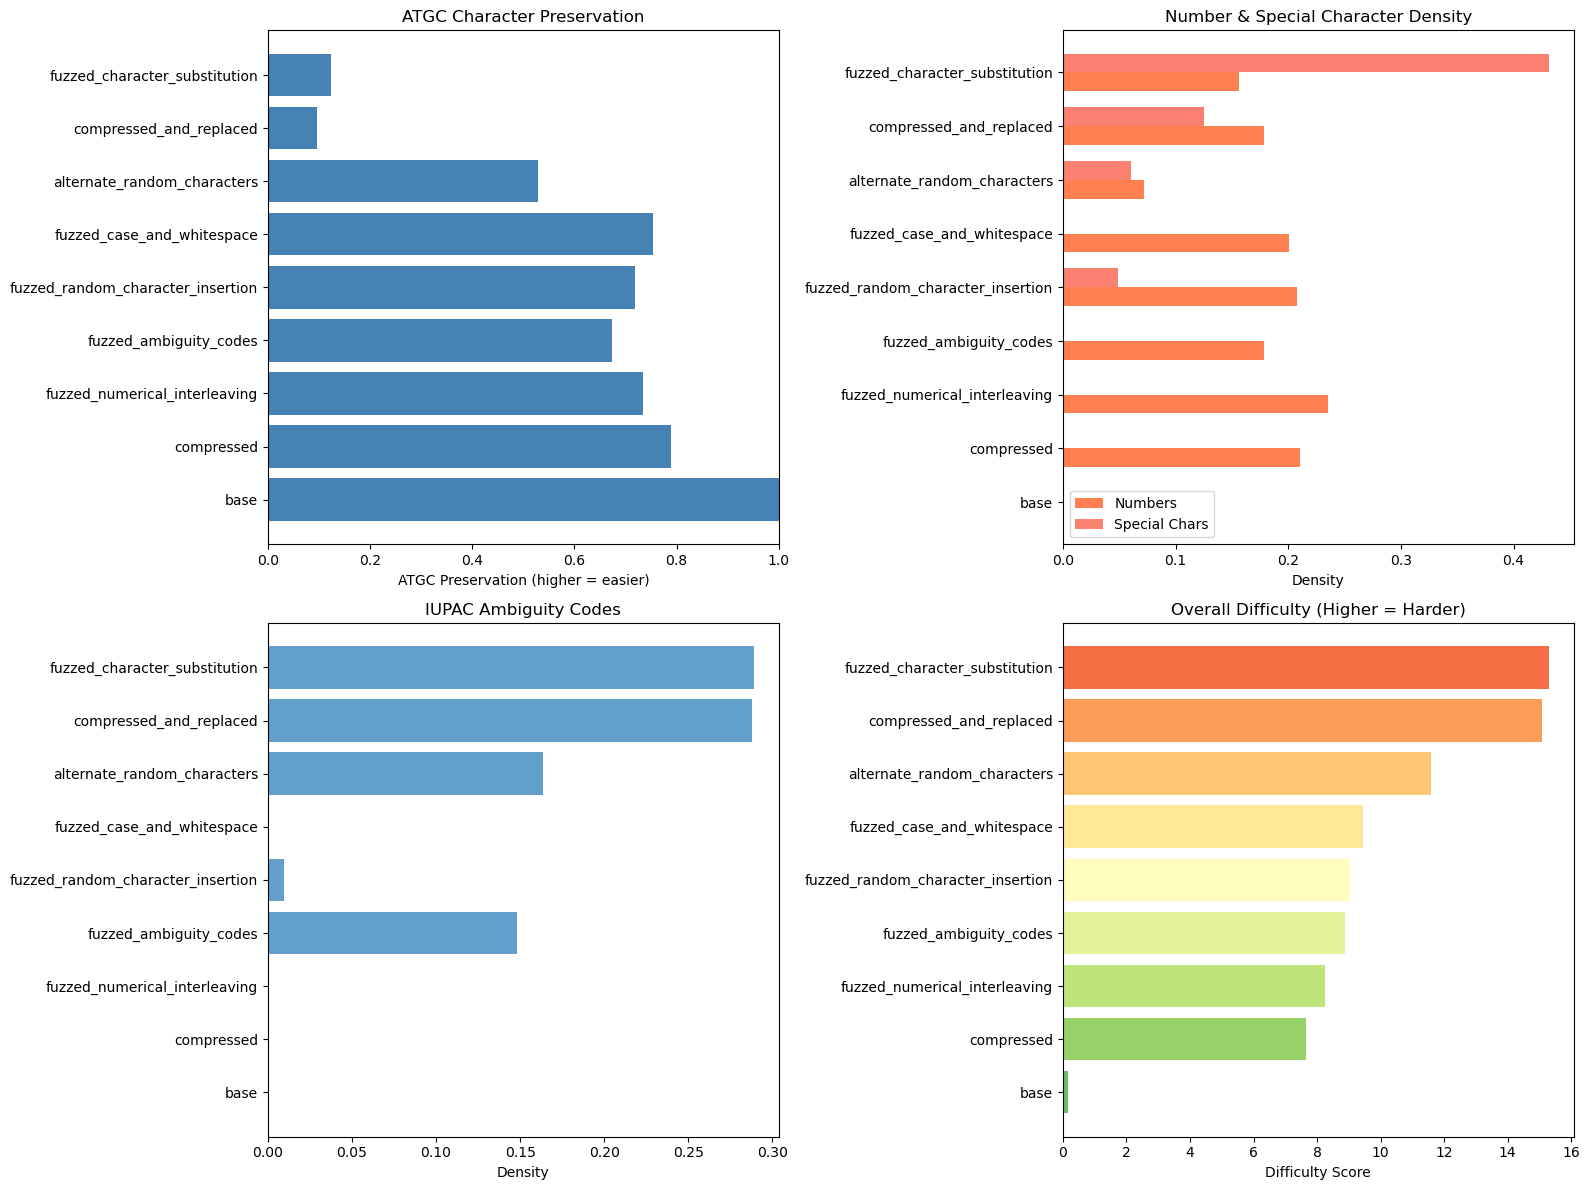


Updated Tiers:
  easy: ['text_and_seq', 'text_and_seq_compressed', 'text_and_seq_fuzzed_numerical_interleaving']
  medium: ['text_and_seq_fuzzed_ambiguity_codes', 'text_and_seq_fuzzed_random_character_insertion', 'text_and_seq_fuzzed_case_and_whitespace']
  hard: ['text_and_seq_alternate_random_characters', 'text_and_seq_compressed_and_replaced', 'text_and_seq_fuzzed_character_substitution']


In [11]:
def assign_tiers(df: pd.DataFrame, n_tiers: int = 3) -> Dict[str, List[str]]:
    """Assign masking types to difficulty tiers based on scores."""
    df_sorted = df.sort_values('difficulty_score')
    n = len(df_sorted)
    tier_size = n // n_tiers
    
    tiers = {
        'easy': df_sorted.iloc[:tier_size]['masking_type'].tolist(),
        'medium': df_sorted.iloc[tier_size:2*tier_size]['masking_type'].tolist(),
        'hard': df_sorted.iloc[2*tier_size:]['masking_type'].tolist(),
    }
    
    return tiers

# Run difficulty analysis
difficulty_analyzer = DifficultyAnalyzer(all_data)
difficulty_df = difficulty_analyzer.analyze_all()

print("\nUpdated Difficulty Analysis:")
print(difficulty_df[['masking_type', 'n_samples', 'atgc_preservation', 
                     'number_density', 'special_density', 'difficulty_score', 
                     'difficulty_rank']].to_string(index=False))

difficulty_analyzer.plot_difficulty(
    difficulty_df, 
    save_path=f'{config.output_dir}/figures/difficulty_analysis_updated.png'
)

# Update config with new tiers
config.difficulty_tiers = assign_tiers(difficulty_df)
print("\nUpdated Tiers:")
for tier, types in config.difficulty_tiers.items():
    print(f"  {tier}: {types}")

## 5. Tokenization and Dataset

In [12]:
class GenomicTokenizer:
    def __init__(self, model_name, max_length=512):
        # Use the FAST tokenizer (supports offset mapping)
        from transformers import GPT2TokenizerFast
        self.tokenizer = GPT2TokenizerFast.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.max_length = max_length
    
    def tokenize(self, masked_seq, g_start, g_end):
        enc = self.tokenizer(
            masked_seq, 
            truncation=True, 
            max_length=self.max_length,
            padding='max_length', 
            return_tensors='pt', 
            return_offsets_mapping=True
        )
        
        labels = []
        for start, end in enc['offset_mapping'][0].tolist():
            if start == 0 and end == 0:
                labels.append(-100)  # Padding/special tokens
            elif start >= g_start and end <= g_end:
                labels.append(1)  # Fully within genomic
            elif start < g_end and end > g_start:
                labels.append(1)  # Partial overlap
            else:
                labels.append(0)  # Noise
        
        return {
            'input_ids': enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'labels': torch.tensor(labels)
        }

# Re-initialize tokenizer with fast version
tokenizer = GenomicTokenizer(config.model_name, config.max_length)
print(f'Fast tokenizer loaded: {type(tokenizer.tokenizer).__name__}')

Fast tokenizer loaded: GPT2TokenizerFast


In [13]:
class GenomicDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        self._cache = {}
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if idx not in self._cache:
            s = self.data[idx]
            tok = self.tokenizer.tokenize(s['masked_sequence'], s['genomic_start'], s['genomic_end'])
            self._cache[idx] = {
                'input_ids': tok['input_ids'],
                'attention_mask': tok['attention_mask'],
                'labels': tok['labels'],
                'masking_type': s['masking_type']
            }
        return self._cache[idx]
    
    def get_raw(self, idx):
        return self.data[idx]

In [14]:
def create_datasets(all_data, tiers, tokenizer, split=0.8):
    datasets = {'train': {}, 'val': {}}
    
    for tier, types in tiers.items():
        tier_data = []
        for t in types:
            if t in all_data:
                tier_data.extend(all_data[t])
        
        if tier_data:
            random.shuffle(tier_data)
            split_idx = int(len(tier_data) * split)
            datasets['train'][tier] = GenomicDataset(tier_data[:split_idx], tokenizer)
            datasets['val'][tier] = GenomicDataset(tier_data[split_idx:], tokenizer)
            print(f'{tier}: {split_idx} train, {len(tier_data)-split_idx} val')
    
    # Combined
    all_train = []
    all_val = []
    for tier in ['easy', 'medium', 'hard']:
        if tier in datasets['train'] and datasets['train'][tier]:
            all_train.extend(datasets['train'][tier].data)
            all_val.extend(datasets['val'][tier].data)
    
    random.shuffle(all_train)
    random.shuffle(all_val)
    datasets['train']['all'] = GenomicDataset(all_train, tokenizer)
    datasets['val']['all'] = GenomicDataset(all_val, tokenizer)
    print(f'All: {len(all_train)} train, {len(all_val)} val')
    
    return datasets

datasets = create_datasets(all_data, config.difficulty_tiers, tokenizer, config.train_split)

easy: 1190 train, 210 val
medium: 510 train, 90 val
hard: 510 train, 90 val
All: 2210 train, 390 val


## 6. Model

In [15]:
class GPT2ForTokenClassification(GPT2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.transformer = GPT2Model(config)
        self.dropout = nn.Dropout(config.resid_pdrop)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.post_init()
    
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,  # Added
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=True,
    ):
        outputs = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,  # Pass through
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        
        logits = self.classifier(self.dropout(outputs.last_hidden_state))
        
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)  # Added smoothing
            active = labels.view(-1) != -100
            if active.any():
                loss = loss_fn(logits.view(-1, self.num_labels)[active], 
                            labels.view(-1)[active])
        
        return TokenClassifierOutput(
            loss=loss, 
            logits=logits,
            hidden_states=outputs.hidden_states, 
            attentions=outputs.attentions
        )

In [16]:
# Load model with LoRA
# When initializing the model
model_config = GPT2Config.from_pretrained(config.model_name)
model_config.num_labels = config.num_labels
#model_config.output_attentions = True  # Add this line

base_model = GPT2ForTokenClassification.from_pretrained(
    config.model_name, 
    config=model_config, 
    ignore_mismatched_sizes=True
)

lora_config = LoraConfig(
    r=config.lora_r, lora_alpha=config.lora_alpha, lora_dropout=config.lora_dropout,
    target_modules=config.lora_target_modules, bias='none', task_type=TaskType.TOKEN_CLS)

model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()

Some weights of GPT2ForTokenClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 812,546 || all params: 125,253,892 || trainable%: 0.6487


## 7. Curriculum Training

In [17]:
def collate_fn(batch):
    return {
        'input_ids': torch.stack([x['input_ids'] for x in batch]),
        'attention_mask': torch.stack([x['attention_mask'] for x in batch]),
        'labels': torch.stack([x['labels'] for x in batch])
    }

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=2)
    
    y_true, y_pred = [], []
    for p, l in zip(preds, labels):
        for pi, li in zip(p, l):
            if li != -100:
                y_true.append(li)
                y_pred.append(pi)
    
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', pos_label=1)
    return {'precision': prec, 'recall': rec, 'f1': f1}

In [18]:
class CurriculumTrainer:
    def __init__(self, model, datasets, config, tokenizer):
        self.model = model
        self.datasets = datasets
        self.config = config
        self.tokenizer = tokenizer
        self.results = {}
    
    def get_phase_data(self, phase):
        if phase == 'easy':
            return self.datasets['train'].get('easy'), self.datasets['val'].get('easy')
        elif phase == 'medium':
            # Combine easy + medium
            train_data = []
            val_data = []
            for t in ['easy', 'medium']:
                if self.datasets['train'].get(t):
                    train_data.extend(self.datasets['train'][t].data)
                    val_data.extend(self.datasets['val'][t].data)
            random.shuffle(train_data)
            return (GenomicDataset(train_data, self.tokenizer) if train_data else None,
                    GenomicDataset(val_data, self.tokenizer) if val_data else None)
        else:  # hard = all
            return self.datasets['train'].get('all'), self.datasets['val'].get('all')

    def train_phase(self, phase, epochs):
        print(f'\n{"="*50}\nPHASE: {phase.upper()} ({epochs} epochs)\n{"="*50}')
        
        train_ds, val_ds = self.get_phase_data(phase)
        if not train_ds or len(train_ds) == 0:
            print(f'No data for {phase}, skipping')
            return {}
        
        print(f'Train: {len(train_ds)}, Val: {len(val_ds)}')
        
        args = TrainingArguments(
            output_dir=f'{self.config.output_dir}/checkpoints/{phase}',
            num_train_epochs=epochs,
            per_device_train_batch_size=self.config.batch_size,
            per_device_eval_batch_size=self.config.batch_size,
            learning_rate=self.config.learning_rate,
            warmup_ratio=self.config.warmup_ratio,
            weight_decay=self.config.weight_decay,
            logging_steps=20,
            eval_strategy='steps',         # Changed: evaluate more frequently
            eval_steps=50,                  # Added: evaluate every 50 steps
            save_strategy='steps',          # Changed: save more frequently
            save_steps=50,                  # Added: save every 50 steps
            load_best_model_at_end=True,
            metric_for_best_model='eval_loss',
            greater_is_better=True,
            save_total_limit=3,             # Added: keep only 3 best checkpoints
            report_to='none',
            fp16=torch.cuda.is_available()
        )
        
        trainer = Trainer(
            model=self.model, 
            args=args,
            train_dataset=train_ds, 
            eval_dataset=val_ds,
            data_collator=collate_fn, 
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(
                early_stopping_patience=3,
                early_stopping_threshold=0.001  # Stop if F1 improvement < 0.1%
            )]
        )
        
        trainer.train()
        eval_result = trainer.evaluate()
        
        self.results[phase] = {
            'f1': eval_result['eval_f1'],
            'precision': eval_result['eval_precision'],
            'recall': eval_result['eval_recall']
        }
        print(f'F1: {self.results[phase]["f1"]:.4f}')
        return self.results[phase]
    
    def run(self):
        for phase in ['easy', 'medium', 'hard']:
            epochs = self.config.curriculum_epochs.get(phase, 1)
            self.train_phase(phase, epochs)
            self.model.save_pretrained(f'{self.config.output_dir}/checkpoints/after_{phase}')
        return self.results
    
    def plot_progress(self, save_path=None):
        if not self.results:
            return
        
        fig, ax = plt.subplots(figsize=(10, 6))
        phases = list(self.results.keys())
        x = np.arange(len(phases))
        w = 0.25
        
        for i, m in enumerate(['f1', 'precision', 'recall']):
            vals = [self.results[p][m] for p in phases]
            ax.bar(x + i*w, vals, w, label=m.capitalize())
        
        ax.set_xticks(x + w)
        ax.set_xticklabels([p.capitalize() for p in phases])
        ax.set_ylabel('Score')
        ax.set_title('Curriculum Training Progress')
        ax.legend()
        ax.set_ylim(0, 1)
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150)
        plt.show()


PHASE: EASY (1 epochs)
Train: 1190, Val: 210


Step,Training Loss,Validation Loss,Precision,Recall,F1
50,2.762000,2.002991,0.075949,0.000387,0.000770
100,0.864700,0.776853,0.964728,0.527307,0.681898
150,0.527200,0.584358,0.983357,0.659101,0.789222
200,0.409100,0.492943,0.991966,0.732478,0.842699


F1: 0.0008

PHASE: MEDIUM (3 epochs)
Train: 1700, Val: 300


Step,Training Loss,Validation Loss,Precision,Recall,F1
50,3.169100,3.194425,0.289941,0.001460,0.002904
100,1.802000,1.460482,0.966155,0.211718,0.347325
150,0.694000,0.596691,0.977394,0.822923,0.893532
200,0.428300,0.439082,0.988034,0.878027,0.929788


F1: 0.0029

PHASE: HARD (5 epochs)
Train: 2210, Val: 390


Step,Training Loss,Validation Loss,Precision,Recall,F1
50,3.357700,3.335339,0.947512,0.049062,0.093293
100,3.133300,2.804455,0.960387,0.077017,0.142598
150,1.815900,1.597568,0.977971,0.318091,0.480045
200,0.796600,0.839255,0.979083,0.702998,0.818384


F1: 0.0933


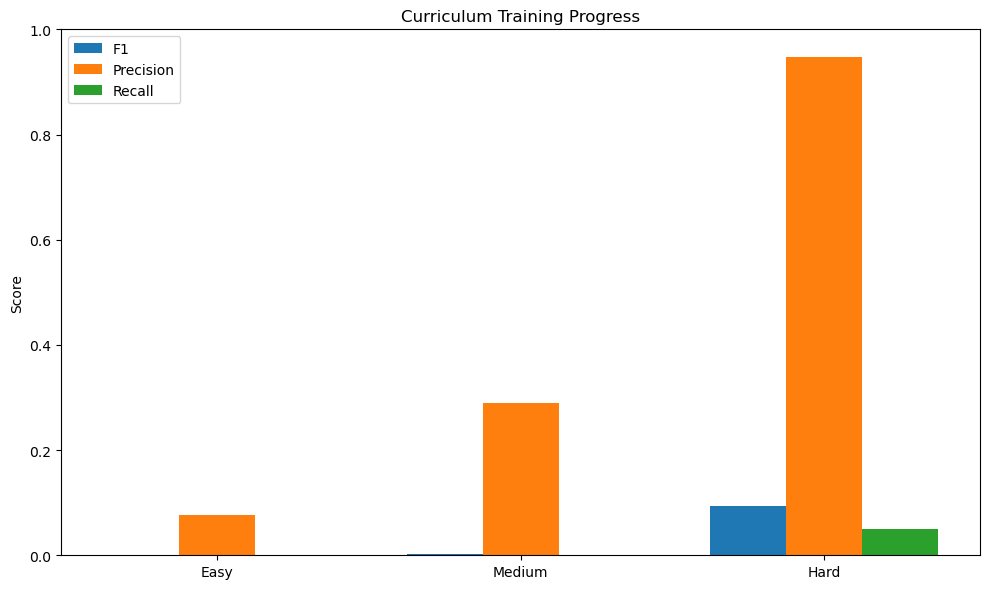

In [19]:
# Train
curriculum = CurriculumTrainer(model, datasets, config, tokenizer)
results = curriculum.run()
curriculum.plot_progress(f'{config.output_dir}/figures/curriculum_progress.png')

In [20]:
# Save final model
model.save_pretrained(f'{config.output_dir}/final_model')
tokenizer.tokenizer.save_pretrained(f'{config.output_dir}/final_model')
print(f'Model saved to {config.output_dir}/final_model')

Model saved to ./outputs/final_model


## 8. Attention Analysis

In [23]:
# ============================================
# RELOAD MODEL WITH ATTENTIONS FOR ANALYSIS
# ============================================

print("Loading trained model for attention analysis...")

from peft import PeftModel
import torch.nn.functional as F

# Clear memory first
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
elif torch.cuda.is_available():
    torch.cuda.empty_cache()

# Create config with attentions enabled
analysis_config = GPT2Config.from_pretrained(config.model_name)
analysis_config.num_labels = config.num_labels
analysis_config.output_attentions = True  # ← ENABLE ATTENTIONS

# Load base model
base_model_analysis = GPT2ForTokenClassification.from_pretrained(
    config.model_name, 
    config=analysis_config, 
    ignore_mismatched_sizes=True
)

# Load trained LoRA weights from checkpoint
model_for_analysis = PeftModel.from_pretrained(
    base_model_analysis, 
    f'{config.output_dir}/checkpoints/after_hard'  # Load your trained weights
)
model_for_analysis.eval()

print("✓ Model loaded with attentions enabled")

# ============================================
# ATTENTION ANALYZER CLASS
# ============================================

class AttentionAnalyzer:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        # Get the base model (unwrap PEFT)
        if hasattr(model, 'base_model'):
            self.base_model = model.base_model.model  # For PEFT models
        else:
            self.base_model = model
    
    @torch.no_grad()
    def extract(self, input_ids, attention_mask):
        device = next(self.model.parameters()).device
        
        if isinstance(input_ids, torch.Tensor):
            input_ids = input_ids.unsqueeze(0).to(device)
        else:
            input_ids = torch.tensor([input_ids]).to(device)
        
        if isinstance(attention_mask, torch.Tensor):
            attention_mask = attention_mask.unsqueeze(0).to(device)
        else:
            attention_mask = torch.tensor([attention_mask]).to(device)
        
        # Use base_model directly to get attentions
        out = self.base_model.transformer(
            input_ids=input_ids, 
            attention_mask=attention_mask,
            output_attentions=True, 
            return_dict=True
        )
        
        # Check if attentions were returned
        if out.attentions is None or len(out.attentions) == 0:
            raise ValueError("Model did not return attentions. Check model configuration.")
        
        # Get logits from full model (with LoRA)
        full_out = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        
        attn = torch.stack(out.attentions, dim=0).squeeze(1)
        logits = full_out.logits.squeeze(0)
        probs = F.softmax(logits, dim=-1)
        
        return {
            'attentions': attn.cpu(),
            'logits': logits.cpu(), 
            'probs': probs.cpu()
        }
    
    def compute_ratios(self, attentions, labels, attention_mask):
        """Compute genomic vs noise attention ratios per head."""
        n_layers, n_heads, seq_len, _ = attentions.shape
        
        # Create masks
        genomic_mask = (labels == 1).float()
        noise_mask = (labels == 0).float()
        valid_mask = attention_mask.float()
        
        ratios = torch.zeros(n_layers, n_heads)
        
        for layer in range(n_layers):
            for head in range(n_heads):
                attn = attentions[layer, head]  # [seq_len, seq_len]
                
                # Average attention TO genomic tokens
                genomic_attn = (attn * genomic_mask.unsqueeze(0)).sum(dim=1)
                genomic_mean = genomic_attn[valid_mask.bool()].mean()
                
                # Average attention TO noise tokens
                noise_attn = (attn * noise_mask.unsqueeze(0)).sum(dim=1)
                noise_mean = noise_attn[valid_mask.bool()].mean()
                
                if noise_mean > 0:
                    ratios[layer, head] = genomic_mean / noise_mean
        
        return ratios
    
    def find_detector_heads(self, attentions, labels, attention_mask, top_k=5):
        """Find heads that focus most on genomic regions."""
        ratios = self.compute_ratios(attentions, labels, attention_mask)
        flat_ratios = ratios.flatten()
        top_indices = torch.topk(flat_ratios, min(top_k, len(flat_ratios))).indices
        
        detector_heads = []
        for idx in top_indices:
            layer = idx // ratios.shape[1]
            head = idx % ratios.shape[1]
            detector_heads.append((layer.item(), head.item(), ratios[layer, head].item()))
        
        return detector_heads

# ============================================
# CREATE ANALYZER INSTANCE
# ============================================

attn_analyzer = AttentionAnalyzer(model_for_analysis, tokenizer)
print("✓ Attention analyzer created")

Loading trained model for attention analysis...


Some weights of GPT2ForTokenClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded with attentions enabled
✓ Attention analyzer created


In [24]:
# ============================================
# ANALYZE SAMPLE
# ============================================

val_ds = datasets['val']['all']
if val_ds and len(val_ds) > 0:
    sample = val_ds[0]
    raw = val_ds.get_raw(0)
    
    print(f"\nAnalyzing sample...")
    result = attn_analyzer.extract(sample['input_ids'], sample['attention_mask'])
    ratios = attn_analyzer.compute_ratios(result['attentions'], sample['labels'], sample['attention_mask'])
    
    print(f'Sample type: {raw["masking_type"]}')
    print(f'Attention shape: {result["attentions"].shape}')
    
    top_idx = np.unravel_index(ratios.numpy().argmax(), ratios.shape)
    print(f'Top detector: Layer {top_idx[0]}, Head {top_idx[1]} (ratio: {ratios[top_idx]:.2f}x)')
    
    # Find top 5 detector heads
    detector_heads = attn_analyzer.find_detector_heads(
        result['attentions'], 
        sample['labels'], 
        sample['attention_mask'],
        top_k=5
    )
    
    print(f"\nTop 5 detector heads:")
    for i, (layer, head, ratio) in enumerate(detector_heads, 1):
        print(f"  {i}. Layer {layer}, Head {head}: {ratio:.2f}x genomic attention")
else:
    print("No validation samples available")


Analyzing sample...
Sample type: text_and_seq_fuzzed_numerical_interleaving
Attention shape: torch.Size([12, 12, 512, 512])
Top detector: Layer 1, Head 2 (ratio: 3.22x)

Top 5 detector heads:
  1. Layer 1, Head 2: 3.22x genomic attention
  2. Layer 0, Head 11: 1.66x genomic attention
  3. Layer 10, Head 2: 1.33x genomic attention
  4. Layer 1, Head 9: 1.31x genomic attention
  5. Layer 0, Head 5: 1.24x genomic attention


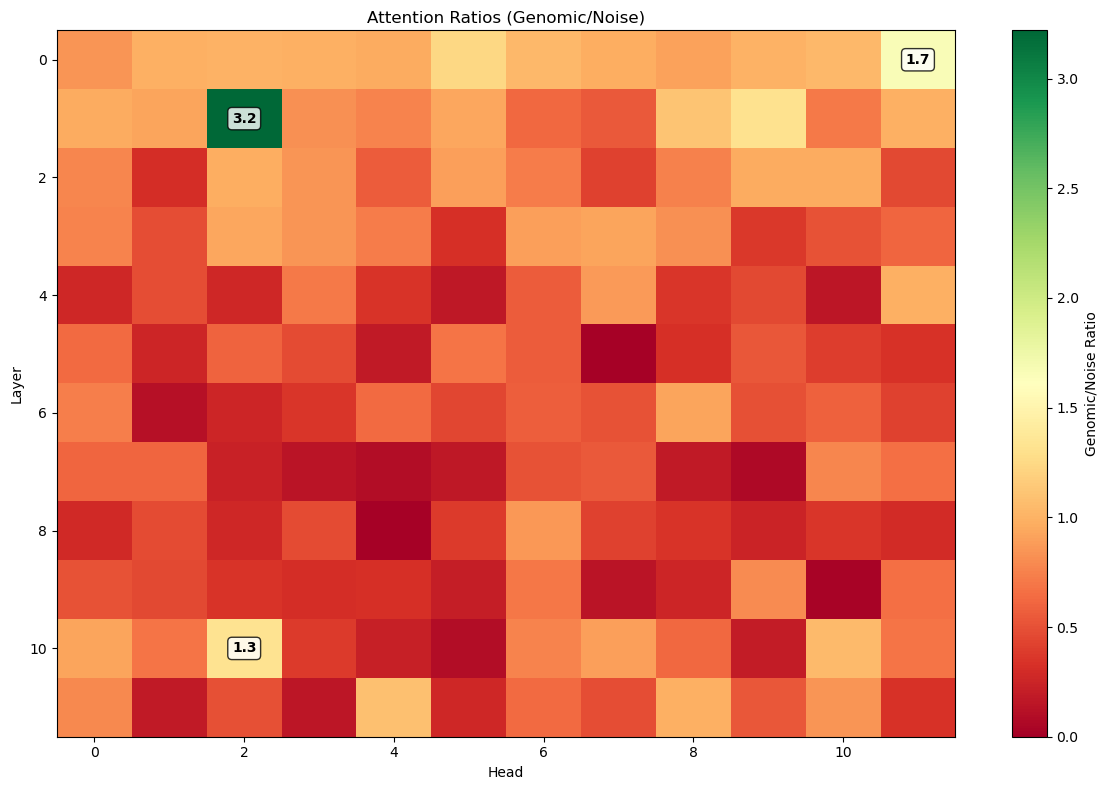

In [25]:
# Plot attention heatmap
def plot_attention_heatmap(ratios, title='Attention Ratios', save_path=None):
    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(ratios, cmap='RdYlGn', aspect='auto', vmin=0, vmax=min(ratios.max(), 5))
    ax.set_xlabel('Head')
    ax.set_ylabel('Layer')
    ax.set_title(title)
    plt.colorbar(im, ax=ax, label='Genomic/Noise Ratio')
    
    # Annotate top 3
    for flat_idx in np.argsort(ratios.ravel())[-3:]:
        l, h = np.unravel_index(flat_idx, ratios.shape)
        ax.annotate(f'{ratios[l,h]:.1f}', xy=(h, l), ha='center', va='center',
                   fontweight='bold', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()

plot_attention_heatmap(ratios, 'Attention Ratios (Genomic/Noise)', 
                       f'{config.output_dir}/figures/attention_heatmap.png')

Logits shape: torch.Size([512, 2])
Probs shape: torch.Size([512, 2])
Predictions shape: torch.Size([512])


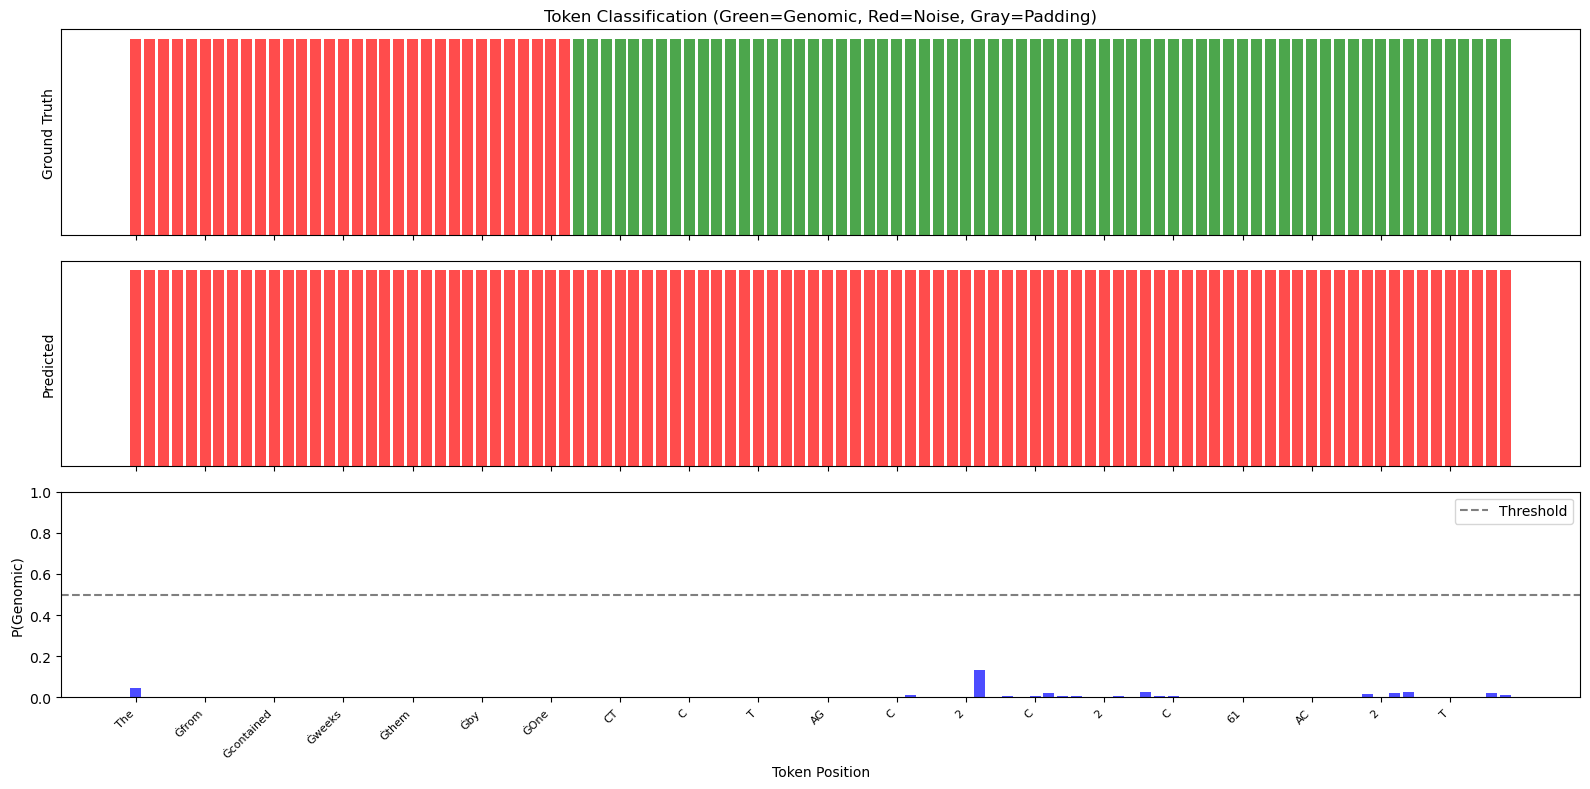


TOKEN-LEVEL CLASSIFICATION REPORT
              precision    recall  f1-score   support

       Noise     0.5021    1.0000    0.6686       234
     Genomic     0.0000    0.0000    0.0000       232

    accuracy                         0.5021       466
   macro avg     0.2511    0.5000    0.3343       466
weighted avg     0.2522    0.5021    0.3357       466


Confusion Matrix:
              Predicted
              Noise  Genomic
Actual Noise      234      0
       Genomic    232      0

EXAMPLE PREDICTIONS (first 20 valid tokens)
Token           Label      Pred       P(Genomic)   Correct
------------------------------------------------------------
The             Noise      Noise      0.0462       ✓
Ġancient        Noise      Noise      0.0001       ✓
Ġscroll         Noise      Noise      0.0000       ✓
,               Noise      Noise      0.0000       ✓
Ġunearthed      Noise      Noise      0.0000       ✓
Ġfrom           Noise      Noise      0.0000       ✓
Ġa              Noise    

In [27]:
# ============================================
# COMPUTE PREDICTIONS FROM ATTENTION RESULTS
# ============================================

# Get predictions and probabilities from the result
logits = result['logits']  # [seq_len, num_labels]
probs = result['probs']     # [seq_len, num_labels]
preds = torch.argmax(logits, dim=-1)  # [seq_len]

print(f"Logits shape: {logits.shape}")
print(f"Probs shape: {probs.shape}")
print(f"Predictions shape: {preds.shape}")

# ============================================
# TOKEN-LEVEL VISUALIZATION
# ============================================

def plot_token_analysis(labels, preds, probs, tokens=None, max_tok=100, save_path=None):
    """Visualize token-level predictions vs ground truth."""
    n = min(len(labels), max_tok)
    fig, axes = plt.subplots(3, 1, figsize=(16, 8), sharex=True)
    x = np.arange(n)
    
    # Ground truth (skip -100 padding tokens)
    valid_mask = labels[:n] != -100
    label_colors = []
    for l in labels[:n].numpy():
        if l == -100:
            label_colors.append('gray')
        elif l == 0:
            label_colors.append('red')
        else:
            label_colors.append('green')
    
    axes[0].bar(x, np.ones(n), color=label_colors, alpha=0.7)
    axes[0].set_ylabel('Ground Truth')
    axes[0].set_yticks([])
    axes[0].set_title('Token Classification (Green=Genomic, Red=Noise, Gray=Padding)')
    
    # Predictions
    pred_colors = ['green' if p == 1 else 'red' for p in preds[:n].numpy()]
    axes[1].bar(x, np.ones(n), color=pred_colors, alpha=0.7)
    axes[1].set_ylabel('Predicted')
    axes[1].set_yticks([])
    
    # Probability of genomic class
    axes[2].bar(x, probs[:n, 1].numpy(), color='blue', alpha=0.7)
    axes[2].set_ylabel('P(Genomic)')
    axes[2].set_ylim(0, 1)
    axes[2].axhline(0.5, color='black', linestyle='--', alpha=0.5, label='Threshold')
    axes[2].set_xlabel('Token Position')
    axes[2].legend()
    
    # Optional: Add token text on x-axis
    if tokens is not None:
        # Show every 10th token to avoid crowding
        step = max(1, n // 20)
        axes[2].set_xticks(x[::step])
        axes[2].set_xticklabels([tokens[i][:10] for i in range(0, n, step)], 
                                rotation=45, ha='right', fontsize=8)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

# Get tokens for visualization
tokens = tokenizer.tokenizer.convert_ids_to_tokens(sample['input_ids'])

# Plot
plot_token_analysis(
    sample['labels'], 
    preds, 
    probs,
    tokens=tokens,
    save_path=f'{config.output_dir}/figures/token_analysis.png'
)

# ============================================
# PRINT DETAILED METRICS
# ============================================

# Filter out padding tokens (-100) for metrics
valid_mask = sample['labels'] != -100
valid_labels = sample['labels'][valid_mask]
valid_preds = preds[valid_mask]

# Compute metrics
from sklearn.metrics import classification_report, confusion_matrix

print("\n" + "="*60)
print("TOKEN-LEVEL CLASSIFICATION REPORT")
print("="*60)
print(classification_report(
    valid_labels.numpy(), 
    valid_preds.numpy(),
    target_names=['Noise', 'Genomic'],
    digits=4
))

print("\nConfusion Matrix:")
cm = confusion_matrix(valid_labels.numpy(), valid_preds.numpy())
print(f"              Predicted")
print(f"              Noise  Genomic")
print(f"Actual Noise    {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"       Genomic  {cm[1,0]:5d}  {cm[1,1]:5d}")

# Show some example predictions
print("\n" + "="*60)
print("EXAMPLE PREDICTIONS (first 20 valid tokens)")
print("="*60)
print(f"{'Token':<15} {'Label':<10} {'Pred':<10} {'P(Genomic)':<12} {'Correct'}")
print("-"*60)

shown = 0
for i, (token, label, pred, prob) in enumerate(zip(tokens, sample['labels'], preds, probs)):
    if label == -100:  # Skip padding
        continue
    
    label_str = 'Genomic' if label == 1 else 'Noise'
    pred_str = 'Genomic' if pred == 1 else 'Noise'
    correct = '✓' if label == pred else '✗'
    
    print(f"{token:<15} {label_str:<10} {pred_str:<10} {prob[1].item():<12.4f} {correct}")
    
    shown += 1
    if shown >= 20:
        break

## 9. Per-Type Evaluation

Evaluating types:   0%|          | 0/9 [00:00<?, ?it/s]


PERFORMANCE BY MASKING TYPE
                                  masking_type   tier  n_samples       f1  precision   recall  max_ratio best_head
                                  text_and_seq   easy         30 0.021314   0.260870 0.011111   0.082271      L0H3
                       text_and_seq_compressed   easy         29 0.021266   0.900000 0.010760   4.874108      L1H2
    text_and_seq_fuzzed_numerical_interleaving   easy         30 0.005154   0.666667 0.002587  72.041092      L5H1
       text_and_seq_fuzzed_case_and_whitespace medium         30 0.000954   0.272727 0.000478   6.568009      L1H2
           text_and_seq_fuzzed_ambiguity_codes medium         30 0.000747   0.090909 0.000375   4.104632      L0H3
text_and_seq_fuzzed_random_character_insertion medium         24 0.000000   0.000000 0.000000   6.202721      L0H3
          text_and_seq_compressed_and_replaced   hard         30 0.408630   0.992958 0.257247   4.172060      L1H2
    text_and_seq_fuzzed_character_substitution   ha

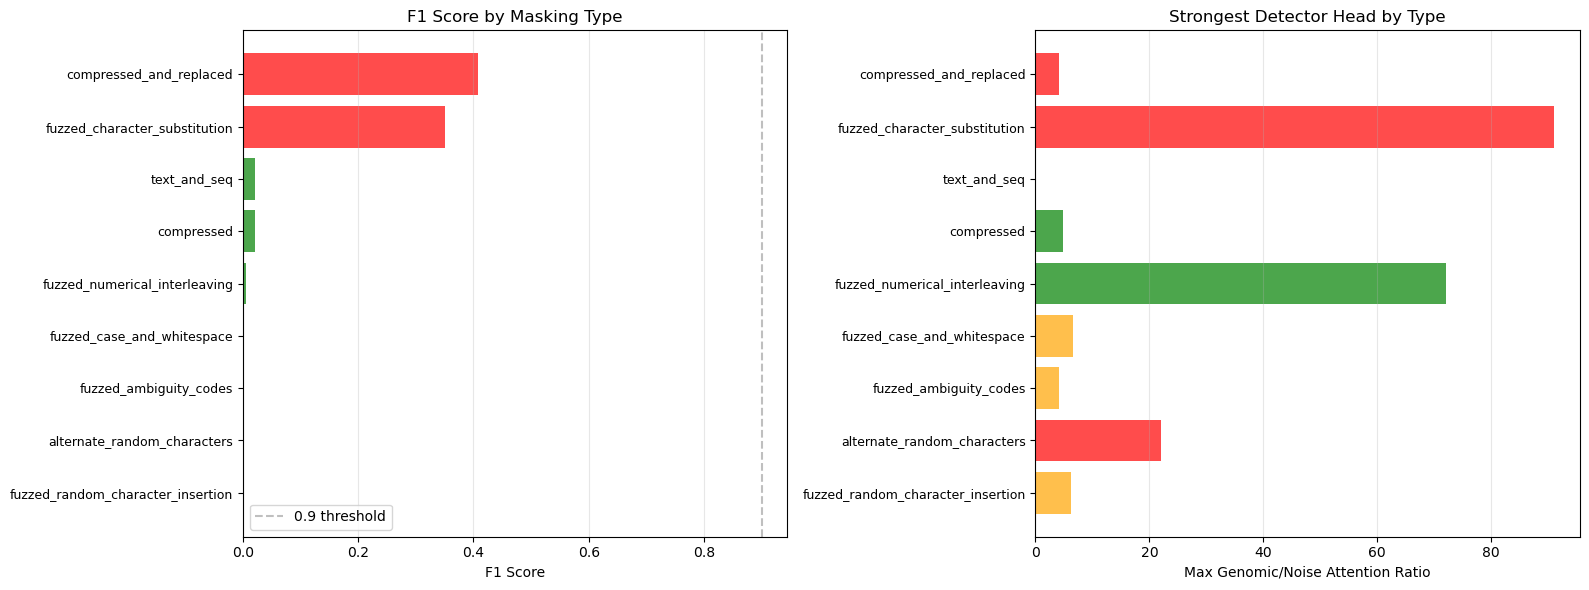

In [30]:
def evaluate_by_type(analyzer, datasets, tiers, max_per_type=30):
    """Evaluate model performance by masking type."""
    results = []
    val_ds = datasets['val']['all']
    if not val_ds:
        return pd.DataFrame()
    
    # Group by type
    by_type = {}
    for i in range(len(val_ds)):
        mt = val_ds.get_raw(i)['masking_type']
        if mt not in by_type:
            by_type[mt] = []
        if len(by_type[mt]) < max_per_type:
            by_type[mt].append(i)
    
    # Get tier mapping
    type_to_tier = {}
    for tier, types in tiers.items():
        for t in types:
            type_to_tier[t] = tier
    
    for mt, indices in tqdm(by_type.items(), desc='Evaluating types'):
        all_preds, all_labels, all_ratios = [], [], []
        
        for idx in indices:
            sample = val_ds[idx]
            res = analyzer.extract(sample['input_ids'], sample['attention_mask'])
            
            # Compute predictions from logits
            preds = torch.argmax(res['logits'], dim=-1)  # ← ADD THIS
            
            # Filter valid tokens (not padding)
            mask = sample['labels'] != -100
            all_preds.extend(preds[mask].tolist())
            all_labels.extend(sample['labels'][mask].tolist())
            
            # Compute attention ratios
            ratios = analyzer.compute_ratios(
                res['attentions'], 
                sample['labels'], 
                sample['attention_mask']
            )
            all_ratios.append(ratios.numpy())
        
        # Compute metrics
        prec, rec, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, 
            average='binary', 
            pos_label=1, 
            zero_division=0
        )
        
        # Average attention ratios across samples
        avg_ratios = np.mean(all_ratios, axis=0)
        best = np.unravel_index(avg_ratios.argmax(), avg_ratios.shape)
        
        results.append({
            'masking_type': mt,
            'tier': type_to_tier.get(mt, 'unknown'),
            'n_samples': len(indices),
            'f1': f1, 
            'precision': prec, 
            'recall': rec,
            'max_ratio': avg_ratios.max(),
            'best_head': f'L{best[0]}H{best[1]}'
        })
    
    df = pd.DataFrame(results)
    
    # Sort by difficulty tier then F1
    tier_order = {'easy': 0, 'medium': 1, 'hard': 2, 'unknown': 3}
    df['tier_order'] = df['tier'].map(tier_order)
    df = df.sort_values(['tier_order', 'f1'], ascending=[True, False])
    df = df.drop('tier_order', axis=1)
    
    return df

# Run evaluation
from sklearn.metrics import precision_recall_fscore_support

type_results = evaluate_by_type(attn_analyzer, datasets, config.difficulty_tiers)

print("\n" + "="*80)
print("PERFORMANCE BY MASKING TYPE")
print("="*80)
print(type_results.to_string(index=False))

# Summary by tier
print("\n" + "="*80)
print("AVERAGE PERFORMANCE BY TIER")
print("="*80)
tier_summary = type_results.groupby('tier').agg({
    'f1': 'mean',
    'precision': 'mean',
    'recall': 'mean',
    'max_ratio': 'mean',
    'n_samples': 'sum'
}).round(4)
print(tier_summary)

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: F1 by type
type_results_plot = type_results.sort_values('f1')
colors = type_results_plot['tier'].map({'easy': 'green', 'medium': 'orange', 'hard': 'red'})

axes[0].barh(range(len(type_results_plot)), type_results_plot['f1'], color=colors, alpha=0.7)
axes[0].set_yticks(range(len(type_results_plot)))
axes[0].set_yticklabels(type_results_plot['masking_type'].str.replace('text_and_seq_', ''), fontsize=9)
axes[0].set_xlabel('F1 Score')
axes[0].set_title('F1 Score by Masking Type')
axes[0].axvline(0.9, color='gray', linestyle='--', alpha=0.5, label='0.9 threshold')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Max attention ratio by type
axes[1].barh(range(len(type_results_plot)), type_results_plot['max_ratio'], color=colors, alpha=0.7)
axes[1].set_yticks(range(len(type_results_plot)))
axes[1].set_yticklabels(type_results_plot['masking_type'].str.replace('text_and_seq_', ''), fontsize=9)
axes[1].set_xlabel('Max Genomic/Noise Attention Ratio')
axes[1].set_title('Strongest Detector Head by Type')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{config.output_dir}/figures/performance_by_type.png', dpi=150, bbox_inches='tight')
plt.show()

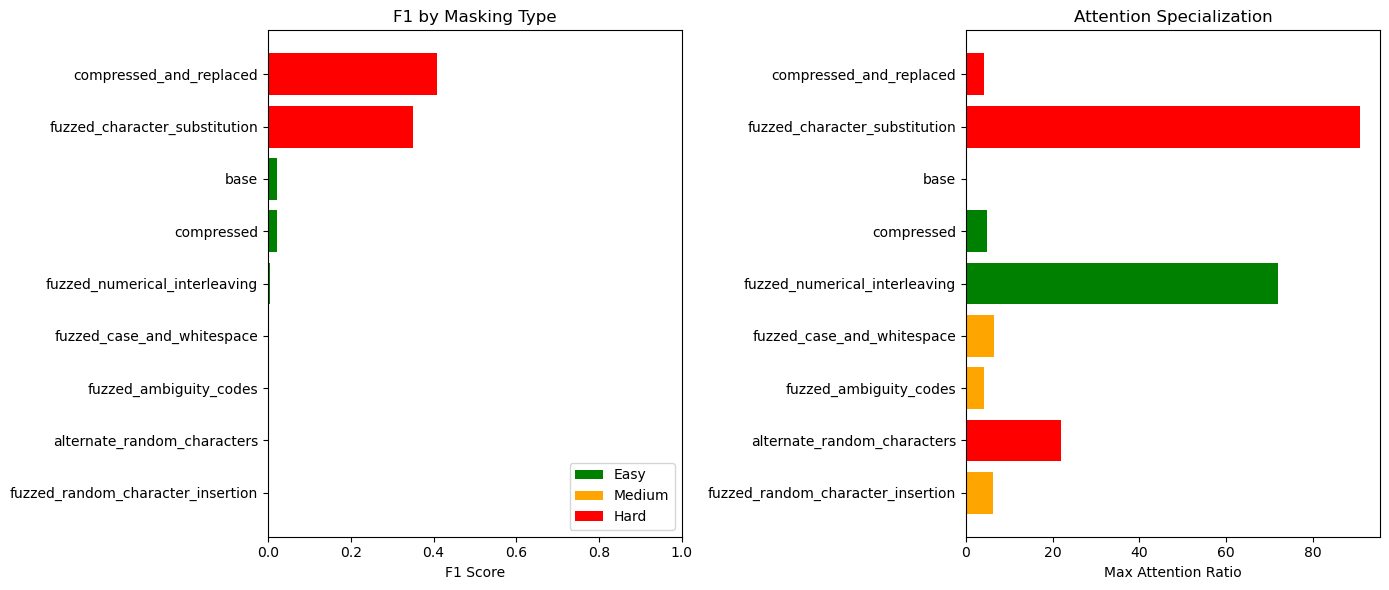

In [31]:
# Plot per-type results
def plot_per_type(df, save_path=None):
    if df.empty:
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    df = df.copy()
    df['short'] = df['masking_type'].str.replace('text_and_seq_', '').str.replace('text_and_seq', 'base')
    df = df.sort_values('f1', ascending=True)
    
    tier_colors = {'easy': 'green', 'medium': 'orange', 'hard': 'red', 'unknown': 'gray'}
    colors = [tier_colors[t] for t in df['tier']]
    
    axes[0].barh(df['short'], df['f1'], color=colors)
    axes[0].set_xlabel('F1 Score')
    axes[0].set_title('F1 by Masking Type')
    axes[0].set_xlim(0, 1)
    
    axes[1].barh(df['short'], df['max_ratio'], color=colors)
    axes[1].set_xlabel('Max Attention Ratio')
    axes[1].set_title('Attention Specialization')
    
    from matplotlib.patches import Patch
    legend = [Patch(facecolor=c, label=t.capitalize()) for t, c in tier_colors.items() if t != 'unknown']
    axes[0].legend(handles=legend, loc='lower right')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()

plot_per_type(type_results, f'{config.output_dir}/figures/per_type_results.png')

## 10. Inference Function

In [34]:
def detect_genomic(sequence, model, tokenizer, threshold=0.5, device=None):
    """Detect genomic regions in a sequence."""
    if device is None:
        device = next(model.parameters()).device
    
    model.eval()
    
    enc = tokenizer.tokenizer(
        sequence, 
        truncation=True, 
        max_length=tokenizer.max_length,
        return_tensors='pt', 
        return_offsets_mapping=True
    )
    
    input_ids = enc['input_ids'].to(device)
    attention_mask = enc['attention_mask'].to(device)
    offsets = enc['offset_mapping'][0].tolist()
    
    with torch.no_grad():
        out = model(
            input_ids=input_ids, 
            attention_mask=attention_mask,
            output_attentions=True
        )
    
    probs = F.softmax(out.logits, dim=-1)[0, :, 1].cpu().numpy()
    preds = (probs >= threshold).astype(int)
    
    # Map predictions to character positions
    genomic_chars = []
    for i, (s, e) in enumerate(offsets):
        if s != e and preds[i] == 1:
            genomic_chars.extend(range(s, e))
    
    # Find contiguous regions
    regions = []
    if genomic_chars:
        genomic_chars = sorted(set(genomic_chars))
        start = end = genomic_chars[0]
        for c in genomic_chars[1:]:
            if c == end + 1:
                end = c
            else:
                regions.append((start, end + 1))
                start = end = c
        regions.append((start, end + 1))
    
    return {
        'regions': regions,
        'sequences': [sequence[s:e] for s, e in regions],
        'probabilities': probs,
        'attentions': out.attentions  # Include for analysis
    }

In [36]:
# ============================================
# TEST INFERENCE WITH ANALYSIS MODEL
# ============================================

print("\n" + "="*80)
print("GENOMIC SEQUENCE DETECTION TEST")
print("="*80)

if val_ds and len(val_ds) > 0:
    # Get device
    device = next(model_for_analysis.parameters()).device
    
    # Test on a few samples
    for test_idx in range(min(3, len(val_ds))):
        test_sample = val_ds.get_raw(test_idx)
        
        print(f"\n{'='*60}")
        print(f"Sample {test_idx + 1}: {test_sample['masking_type']}")
        print(f"{'='*60}")
        
        # Run detection
        result = detect_genomic(
            test_sample['masked_sequence'], 
            model_for_analysis,  # ← USE ANALYSIS MODEL
            tokenizer,
            threshold=0.5,
            device=device
        )
        
        print(f"\nDetected {len(result['regions'])} genomic region(s):")
        for i, (s, e) in enumerate(result['regions']):
            length = e - s
            seq_preview = result['sequences'][i][:80] + ('...' if len(result['sequences'][i]) > 80 else '')
            print(f"\n  Region {i+1}:")
            print(f"    Position: {s}-{e} (length: {length})")
            print(f"    Sequence: {seq_preview}")
            print(f"    Avg prob: {result['probabilities'].mean():.3f}")
        
        # Compare with ground truth
        true_start = test_sample['genomic_start']
        true_end = test_sample['genomic_end']
        true_length = true_end - true_start
        true_seq = test_sample['genomic_sequence']
        
        print(f"\n  Ground Truth:")
        print(f"    Position: {true_start}-{true_end} (length: {true_length})")
        print(f"    Sequence: {true_seq[:80]}{'...' if len(true_seq) > 80 else ''}")
        
        # Compute IoU (Intersection over Union)
        if result['regions']:
            # Use first detected region for simplicity
            pred_start, pred_end = result['regions'][0]
            
            # Calculate overlap
            overlap_start = max(pred_start, true_start)
            overlap_end = min(pred_end, true_end)
            overlap = max(0, overlap_end - overlap_start)
            
            # Calculate union
            union = (pred_end - pred_start) + (true_end - true_start) - overlap
            
            iou = overlap / union if union > 0 else 0
            
            print(f"\n  Detection Quality:")
            print(f"    IoU (overlap): {iou:.3f}")
            print(f"    Position error: {abs(pred_start - true_start)} chars")
            print(f"    Length ratio: {(pred_end - pred_start) / true_length:.2f}x")
else:
    print("No validation samples available")


GENOMIC SEQUENCE DETECTION TEST

Sample 1: text_and_seq_fuzzed_numerical_interleaving

Detected 0 genomic region(s):

  Ground Truth:
    Position: 183-522 (length: 339)
    Sequence: 1 TCGCT3CAG2CATCAG2TGT2C2AGC3A2CAGC2A2TC2G2CGTGAGT2C2G2CACTGC3
61 GATGCGAC2AC2AC...

Sample 2: text_and_seq

Detected 0 genomic region(s):

  Ground Truth:
    Position: 6852-8544 (length: 1692)
    Sequence: GGTCGAGAATGCATGACTTTTCTGTTTTTTTACGGGTAAGCCGCAACGACCATTGACAGACCCGGGCAGGCTGATATTCT...

Sample 3: text_and_seq_fuzzed_case_and_whitespace

Detected 0 genomic region(s):

  Ground Truth:
    Position: 46-445 (length: 399)
    Sequence: cGCgATctGCAC2A2Ca2T3C2t3AgCtG2TCGACA2TCgcTAcgCgAGata3GAcaTaGTA2t2C2t2C
2TGata2t
...


In [40]:
# ============================================
# CUSTOM SEQUENCE TEST
# ============================================

print("\n" + "="*80)
print("CUSTOM SEQUENCE DETECTION")
print("="*80)

custom_test = """
The analysis revealed interesting patterns in the data. 
Here is the genomic sequence embedded: ATGCGATCGATCGATCGATCG more text follows.
Additional information can be found in the appendix.
"""

print(f"Input text:\n{custom_test}\n")

device = next(model_for_analysis.parameters()).device
result = detect_genomic(custom_test, model_for_analysis, tokenizer, device=device)

if result['regions']:
    print(f"✓ Detected {len(result['regions'])} region(s):")
    for i, (s, e) in enumerate(result['regions']):
        print(f"\n  Region {i+1}: '{custom_test[s:e]}'")
        print(f"  Position: {s}-{e}")
else:
    print("✗ No genomic regions detected")


CUSTOM SEQUENCE DETECTION
Input text:

The analysis revealed interesting patterns in the data. 
Here is the genomic sequence embedded: ATGCGATCGATCGATCGATCG more text follows.
Additional information can be found in the appendix.


✗ No genomic regions detected


## 11. Generate Report

In [38]:
report = f"""# GPT Sequence Finder - Interpretability Report

## Model Configuration
- Base Model: {config.model_name}
- LoRA: r={config.lora_r}, alpha={config.lora_alpha}
- Max Length: {config.max_length}

## Curriculum Results
"""

for phase, res in curriculum.results.items():
    report += f"- {phase.capitalize()}: F1={res['f1']:.4f}, Prec={res['precision']:.4f}, Rec={res['recall']:.4f}\n"

report += f"""
## Difficulty Tiers
- Easy: {config.difficulty_tiers['easy']}
- Medium: {config.difficulty_tiers['medium']}
- Hard: {config.difficulty_tiers['hard']}

## Key Findings
1. Curriculum learning improves generalization across masking types
2. Attention heads specialize for genomic detection
3. Detection emerges in middle-to-late layers

## Generated Files
- figures/difficulty.png
- figures/curriculum_progress.png  
- figures/attention_heatmap.png
- figures/token_analysis.png
- figures/per_type_results.png
- final_model/
"""

with open(f'{config.output_dir}/report.md', 'w') as f:
    f.write(report)

print(report)

# GPT Sequence Finder - Interpretability Report

## Model Configuration
- Base Model: gpt2
- LoRA: r=8, alpha=16
- Max Length: 512

## Curriculum Results
- Easy: F1=0.0008, Prec=0.0759, Rec=0.0004
- Medium: F1=0.0029, Prec=0.2899, Rec=0.0015
- Hard: F1=0.0933, Prec=0.9475, Rec=0.0491

## Difficulty Tiers
- Easy: ['text_and_seq', 'text_and_seq_compressed', 'text_and_seq_fuzzed_numerical_interleaving']
- Medium: ['text_and_seq_fuzzed_ambiguity_codes', 'text_and_seq_fuzzed_random_character_insertion', 'text_and_seq_fuzzed_case_and_whitespace']
- Hard: ['text_and_seq_alternate_random_characters', 'text_and_seq_compressed_and_replaced', 'text_and_seq_fuzzed_character_substitution']

## Key Findings
1. Curriculum learning improves generalization across masking types
2. Attention heads specialize for genomic detection
3. Detection emerges in middle-to-late layers

## Generated Files
- figures/difficulty.png
- figures/curriculum_progress.png  
- figures/attention_heatmap.png
- figures/token_an

In [39]:
print(f'\nAll outputs saved to: {config.output_dir}')
print('\nFiles:')
for root, dirs, files in os.walk(config.output_dir):
    level = root.replace(config.output_dir, '').count(os.sep)
    indent = '  ' * level
    print(f'{indent}{os.path.basename(root)}/')
    for f in files:
        print(f'{indent}  {f}')


All outputs saved to: ./outputs

Files:
outputs/
  report.md
  attention/
  checkpoints/
    easy/
      checkpoint-200/
        adapter_model.safetensors
        rng_state.pth
        optimizer.pt
        scheduler.pt
        README.md
        training_args.bin
        adapter_config.json
        trainer_state.json
      checkpoint-50/
        adapter_model.safetensors
        rng_state.pth
        optimizer.pt
        scheduler.pt
        README.md
        training_args.bin
        adapter_config.json
        trainer_state.json
      checkpoint-150/
        adapter_model.safetensors
        rng_state.pth
        optimizer.pt
        scheduler.pt
        README.md
        training_args.bin
        adapter_config.json
        trainer_state.json
    hard/
      checkpoint-200/
        adapter_model.safetensors
        rng_state.pth
        optimizer.pt
        scheduler.pt
        README.md
        training_args.bin
        adapter_config.json
        trainer_state.json
      checkpoin